In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pywt
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import BayesianGaussianMixture
from hmmlearn.hmm import GMMHMM
from scipy.stats import anderson_ksamp, norm
import time
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler


plt.rcParams['figure.figsize'] = [15, 5]
plt.style.use('seaborn-deep');

## Data preparation

In [8]:
asks = pd.read_csv('Asks.csv', header=None)
bids = pd.read_csv('Bids.csv', header=None)

col_names = ['time']
lv = 1
for i in range(1, asks.shape[1], 3):
    col_names.append('order'+str(lv))
    col_names.append('price'+str(lv))
    col_names.append('volume'+str(lv))
    lv += 1

asks.columns = col_names
bids.columns = col_names
asks.head(3)

time       order1        price1   volume1       order2  \
0  1.604030e+09  53001558049  13437.000000 -1.000000  53006686518   
1  1.604030e+09  53006737904  13435.043112 -0.041757  53006686518   
2  1.604030e+09  53006737906  13433.766176 -0.010000  53006737904   

         price2   volume2       order3   price3   volume3  ...  volume97  \
0  13437.000000 -0.400040  53006729547  13437.0 -0.022328  ... -4.199900   
1  13436.000000 -0.384894  53006730643  13436.0 -0.106472  ... -0.312879   
2  13433.874034 -0.041757  53006686518  13434.0 -0.384911  ... -1.114421   

       order98  price98  volume98      order99       price99  volume99  \
0  53006740985  13468.0 -1.487708  53001297177  13469.000000   -2.6497   
1  53006727209  13470.0 -0.148757  52955915169  13470.430324   -0.5689   
2  52999487837  13465.0 -2.320000  52999487845  13465.000000   -2.3200   

      order100      price100  volume100  
0  53006634551  13469.000000  -0.312879  
1  52986159744  13470.430324  -1.729846  
2  53005332351  13465.000000  -3.000000  

[3 rows x 301 columns]

In [9]:
for l in range(1, 101):
    asks['volume'+str(l)] = asks['volume'+str(l)] * (-1) #make ask volume positive

## Feature engineering

In [10]:
#Order imbalance
def micro_var(lv, rolling_window, df_bid, df_ask):
    OI = (df_bid['volume'+str(lv)] - df_ask['volume'+str(lv)]) / (df_bid['volume'+str(lv)] + df_ask['volume'+str(lv)]) 
    QS = (df_ask['price'+str(lv)] - df_bid['price'+str(lv)]) * 100 / ((df_ask['price'+str(lv)] + df_bid['price'+str(lv)])/2) 
    ret_sqrt_ask = (np.log(df_ask['price'+str(lv)]) - np.log(df_ask['price'+str(lv)].shift(1)))**2
    ret_sqrt_ask = ret_sqrt_ask.rolling(rolling_window).sum()
    ret_sqrt_bid = (np.log(df_bid['price'+str(lv)]) - np.log(df_bid['price'+str(lv)].shift(1)))**2
    ret_sqrt_bid = ret_sqrt_bid.rolling(rolling_window).sum()
    return  pd.Series(OI), pd.Series(QS), pd.Series(ret_sqrt_ask), pd.Series(ret_sqrt_bid)

In [11]:
def make_df(lv, window, df_bid, df_ask):
    ask_prices = df_ask['price' + str(lv)]
    bid_prices = df_bid['price' + str(lv)]
    ask_prices_grad = pd.Series(np.gradient(ask_prices, 1))
    bid_prices_grad = pd.Series(np.gradient(bid_prices, 1))
    imbalance, spread, ask_volatility, bid_volatility = micro_var(lv, window, df_bid, df_ask)

    df = pd.concat([ask_prices, ask_prices_grad, ask_volatility, bid_prices, bid_prices_grad, bid_volatility, imbalance, spread], axis = 1)
    names = ['ask_price', 'ask_price_grad', 'ask_volat', 'bid_price', 'bid_price_grad', 'bid_volat', 'imbalance', 'spread']
    df.columns = names
    df.dropna(inplace=True)
    df.reset_index(inplace=True)
    df.drop(columns='index', inplace=True)
    return df

def DWT(df, str_):
    (ca, cd) = pywt.dwt(df[str_+'_price'], 'sym2', 'smooth')
    sigma_wv = np.median(np.abs(cd)) / 0.6745
    thresh_wv = sigma_wv * np.sqrt(2*np.log(len(df[str_+'_price'])))
    cd[np.abs(cd) < thresh_wv] = 0
    ts_recons = pywt.idwt(ca, cd, 'sym2', 'smooth')
    return ts_recons

def make_small_df(df):
    df.reset_index(inplace=True)
    df.drop(columns='index', inplace=True)
    df['ask_dwt'] = pd.Series(DWT(df, 'ask'), dtype='float64')
    df['bid_dwt'] = pd.Series(DWT(df, 'bid'), dtype='float64')
    df['ask_dwt_grad'] = pd.Series(np.gradient(df['ask_dwt'], 1))
    df['bid_dwt_grad'] = pd.Series(np.gradient(df['bid_dwt'], 1))
    for c in df.columns: 
        scaler = MinMaxScaler()
        df[c] = scaler.fit_transform(np.array(df[c]).reshape(-1, 1))
    return df

In [12]:
window_size = 12 #minute
lv1_df = make_df(1, window_size, bids, asks)
lv2_df = make_df(2, window_size, bids, asks)
lv3_df = make_df(3, window_size, bids, asks)
lv4_df = make_df(4, window_size, bids, asks)
lv5_df = make_df(5, window_size, bids, asks)
lv6_df = make_df(6, window_size, bids, asks)
lv7_df = make_df(7, window_size, bids, asks)
lv8_df = make_df(8, window_size, bids, asks)
lv9_df = make_df(9, window_size, bids, asks)
lv10_df = make_df(10, window_size, bids, asks)

In [111]:
train_size = 731*14
lv1_df_train = lv1_df.iloc[:train_size, :] #training set
lv1_df_train = make_small_df(lv1_df_train)
lv1_df_train.head()

ask_price  ask_price_grad  ask_volat  bid_price  bid_price_grad  bid_volat  \
0   0.698871        0.506833   0.012208   0.699823        0.507794   0.013155   
1   0.716508        0.506833   0.042473   0.716245        0.514641   0.042312   
2   0.716508        0.397241   0.041652   0.717848        0.416718   0.040439   
3   0.716508        0.438338   0.041652   0.717848        0.437867   0.040439   
4   0.723122        0.438338   0.046175   0.722998        0.437867   0.043382   

   imbalance    spread   ask_dwt   bid_dwt  ask_dwt_grad  bid_dwt_grad  
0   0.295447  0.032971  0.698697  0.699761      0.623253      0.606440  
1   0.285714  0.097144  0.716533  0.716427      0.501427      0.502579  
2   0.856322  0.011309  0.714417  0.715411      0.412244      0.426547  
3   0.042940  0.011309  0.717647  0.719133      0.445502      0.445745  
4   0.857143  0.089331  0.720978  0.721386      0.445953      0.439426

## Model training

In [102]:
dict_of_components = dict()
for col in lv1_df_train.columns:
    X = np.array(lv1_df_train[col]).reshape(-1, 1)
    GMM_comp = BayesianGaussianMixture(n_components=10, random_state=1)
    GMM_comp.fit(X)
    n_component = GMM_comp.weights_[GMM_comp.weights_>0.05].shape[0]
    dict_of_components[col] = n_component

components_df = pd.DataFrame(dict_of_components.values())
components_df=components_df.transpose()
components_df.columns = dict_of_components.keys()
print('Median number of components is {}'.format(int(components_df.iloc[0,:].median())))
components_df

Median number of components is 6


ask_price  ask_price_grad  ask_volat  bid_price  bid_price_grad  bid_volat  \
0          8               6          4          7               6          4   

   imbalance  spread  ask_dwt  bid_dwt  ask_dwt_grad  bid_dwt_grad  
0          8       4        7        7             7             6

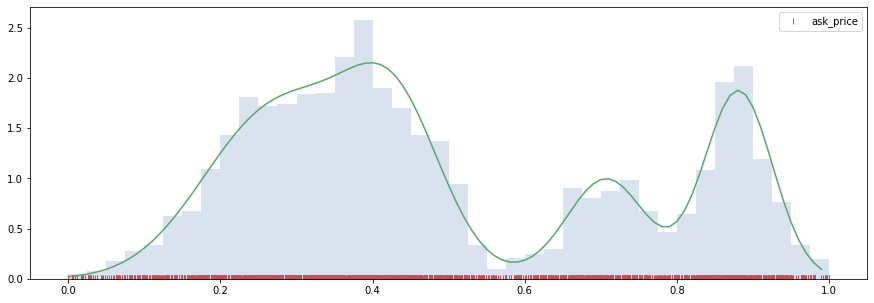

In [104]:
сol_name = 'ask_price'
def mix_pdf(x, loc, scale, weights):
    d = np.zeros_like(x)
    for mu, sigma, pi in zip(loc, scale, weights):
        d += pi * norm.pdf(x, loc=mu, scale=sigma)
    return d

mix = BayesianGaussianMixture(n_components=6, random_state=1).fit(np.array(lv1_df_train[сol_name]).reshape(-1, 1))
pi, mu, sigma = mix.weights_.flatten(), mix.means_.flatten(), np.sqrt(mix.covariances_.flatten())

grid = np.arange(np.min(lv1_df_train[сol_name]), np.max(lv1_df_train[сol_name]), 0.01)

plt.hist(lv1_df_train[сol_name], bins=40, density=True, alpha=0.2)
plt.plot(grid, mix_pdf(grid, mu, sigma, pi))
plt.plot(lv1_df_train[сol_name], [0.01]*lv1_df_train[сol_name].shape[0], '|', label = сol_name)
plt.legend(loc='upper right')
plt.show()

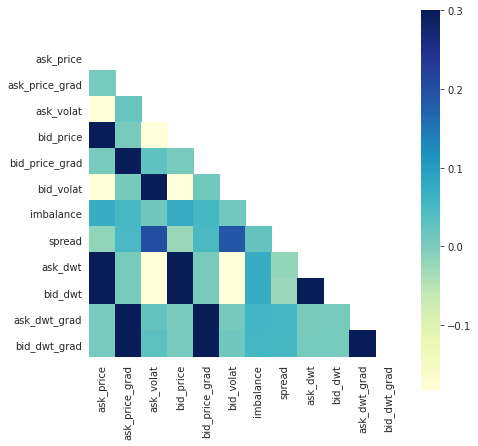

In [105]:
corr = lv1_df_train.corr() #low correlation among features
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(7, 7))
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True, cmap="YlGnBu")

We can use diagonal covariances because features are not higher correlated. We use median value of 9 components in Gaussian Mixture Model. We use 9 states because assume that each component generates 9 states and there are at most 9 classes produced by OPTICS clustering.

In [106]:
def BIC_AIC(df, model, n_states, n_mix):
    n = df.shape[0]
    MLL = model.score(df.values)
    means_weights = 2*n_mix*n_states#means, weights
    trans_pobs = n_states**2
    pi = n_states
    covar = n_mix*n_states*df.shape[1]
    n_params = covar+pi+trans_pobs+means_weights
    BIC_score = n_params*np.log(n)-2*np.log(MLL)
    AIC_score = 2*n_params-2*np.log(MLL)
    print("BIC for the model with " +str(n_states)+" states is "+str(round(BIC_score, 4)))
    print("AIC for the model with " +str(n_states)+" states is "+str(round(AIC_score, 4)))

In [107]:
for state_num in range(1, 20):
    HMM = GMMHMM(n_components=state_num, n_mix = 6, algorithm = 'viterbi', random_state = 1, covariance_type = 'diag').fit(lv1_df_train.values)
    BIC_AIC(lv1_df_train, HMM, state_num, 7)

BIC for the model with 1 states is 899.2957
AIC for the model with 1 states is 175.9487
BIC for the model with 2 states is 1840.8222
AIC for the model with 2 states is 379.6611
BIC for the model with 3 states is 2800.9756
AIC for the model with 3 states is 587.5335
BIC for the model with 4 states is 3779.6317
AIC for the model with 4 states is 799.4417
BIC for the model with 5 states is 4776.75
AIC for the model with 5 states is 1015.3452
BIC for the model with 6 states is 5792.3781
AIC for the model with 6 states is 1235.2915
BIC for the model with 7 states is 6826.4961
AIC for the model with 7 states is 1459.2608
BIC for the model with 8 states is 7879.0609
AIC for the model with 8 states is 1687.2099
BIC for the model with 9 states is 8950.1204
AIC for the model with 9 states is 1919.1867
BIC for the model with 10 states is 10039.6195
AIC for the model with 10 states is 2155.1364
BIC for the model with 11 states is 11147.6391
AIC for the model with 11 states is 2395.1394
BIC for the

In [112]:
HMM = GMMHMM(n_components=6, n_mix = 6, algorithm = 'viterbi', random_state = 1, covariance_type = 'diag').fit(lv1_df_train.values)

We are looking for outliers, so are more interested in the tails of distribution that its center, hence use Anderson Darling test, not Kolmogorov Smirnov. It can be used for different sample sizes.

https://www.itl.nist.gov/div898/handbook/eda/section3/eda35e.htm

https://stats.stackexchange.com/questions/201434/2-sample-kolmogorov-smirnov-vs-anderson-darling-vs-cramer-von-mises#:~:text=Anderson-Darling%20test%20is%20much,get%20much%20more%20powerful%20test.

In [113]:
print(time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime(time.time())))
states = np.full((lv1_df.shape[0], 12), -1, dtype ='float64')
end = 731
sliding_window = 12 # 12 in a minute
h = 0
for i in range(17000):
    if lv1_df.shape[0] - end >= sliding_window:
        dataset = lv1_df.iloc[h:end, :].copy()
        dataset = make_small_df(dataset)
        if end > train_size:
            temp_df = make_small_df(lv1_df.iloc[end-train_size:end, :])
            for cc in lv1_df.columns:
                ADtest = anderson_ksamp([np.array(temp_df[cc]), np.array(lv1_df_train[cc])])
                if ADtest[0] > ADtest[1][2]: #test at 5% significance 4
                    print(i)
                    HMM = GMMHMM(n_components=6, n_mix = 6, algorithm = 'viterbi', random_state = 1, covariance_type = 'diag').fit(temp_df.values)    
                    lv1_df_train = temp_df
                    break
        for pos, c in enumerate(dataset.columns):
            probs, st = HMM.decode(np.array(dataset[c]).reshape(-1, 1), algorithm='viterbi')
            if h == 0:
                states[:end, pos] = st
            else:
                states[end-sliding_window:end, pos] = st[-sliding_window:]

        end += sliding_window
        h += sliding_window
    else:
        dataset = lv1_df.iloc[h:, :].copy()
        dataset = make_small_df(dataset)
        temp_df = make_small_df(lv1_df.iloc[end-train_size:end, :])
        for cc in dataset.columns:
                ADtest = anderson_ksamp([np.array(temp_df[cc]),np.array(lv1_df_train[cc])])
                if ADtest[0] > ADtest[1][]: #test at 1% significance
                    HMM = GMMHMM(n_components=6, n_mix = 6, algorithm = 'viterbi', random_state = 1, covariance_type = 'diag').fit(temp_df.values)
                    break
        for pos, c in enumerate(dataset.columns):
            probs, st = HMM.decode(np.array(dataset[c]).reshape(-1, 1), algorithm='viterbi')
            states[-(lv1_df.shape[0] - end):, pos] = st[-(lv1_df.shape[0] - end):]
        break

print(time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime(time.time())))

2021-02-26 19:01:59
811
827
851
865
880
893
903
904
907
908
911
912
917
918
922
923
933
941
946
957
967
976
984
992
998
999
1007
1016
1024
1032
1042
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate 

In [114]:
states_df = pd.DataFrame(states, columns=lv1_df_train.columns)
states_df.head()

ask_price  ask_price_grad  ask_volat  bid_price  bid_price_grad  \
0            4.0             4.0        4.0        4.0             4.0   
1            0.0             4.0        0.0        0.0             4.0   
2            2.0             0.0        5.0        2.0             0.0   
3            2.0             2.0        5.0        2.0             2.0   
4            2.0             2.0        5.0        2.0             2.0   
...          ...             ...        ...        ...             ...   
17532        2.0             2.0        0.0        2.0             2.0   
17533        2.0             2.0        0.0        2.0             2.0   
17534        2.0             0.0        0.0        2.0             0.0   
17535        2.0             0.0        0.0        2.0             0.0   
17536        2.0             0.0        0.0        2.0             0.0   

       bid_volat  imbalance  spread  ask_dwt  bid_dwt  ask_dwt_grad  \
0            4.0        4.0     4.0      4.0      4.0           4.0   
1            0.0        0.0     0.0      0.0      0.0           0.0   
2            5.0        4.0     5.0      2.0      2.0           2.0   
3            5.0        0.0     5.0      2.0      2.0           2.0   
4            5.0        4.0     5.0      2.0      2.0           2.0   
...          ...        ...     ...      ...      ...           ...   
17532        0.0        0.0     0.0      2.0      2.0           2.0   
17533        0.0        2.0     0.0      2.0      2.0           2.0   
17534        0.0        2.0     0.0      2.0      2.0           0.0   
17535        0.0        2.0     0.0      2.0      2.0           0.0   
17536        0.0        0.0     0.0      2.0      2.0           0.0   

       bid_dwt_grad  
0               4.0  
1               4.0  
2               0.0  
3               2.0  
4               2.0  
...             ...  
17532           2.0  
17533           2.0  
17534           0.0  
17535           0.0  
17536           0.0  

[17537 rows x 12 columns]

In [13]:
states_df = pd.read_csv('lv1_labels_model_1.csv')
states_df.drop(columns = 'Unnamed: 0', inplace = True)
states_df.groupby('spread').mean()

ask_price  ask_price_grad  ask_volat  bid_price  bid_price_grad  \
spread                                                                    
-1.0    -1.000000       -1.000000  -1.000000  -1.000000       -1.000000   
 0.0     0.751050        1.608193   0.694328   0.838235        1.556723   
 1.0     2.313458        2.850085   1.695060   2.318569        2.846678   
 2.0     2.695747        2.700109   2.395311   2.706652        2.671210   
 3.0     2.613008        2.647154   2.921138   2.653659        2.582114   
 4.0     2.829909        2.485160   3.468037   2.851027        2.578196   
 5.0     3.666697        2.719606   4.672874   3.667323        2.672784   

        bid_volat  imbalance   ask_dwt   bid_dwt  ask_dwt_grad  bid_dwt_grad  
spread                                                                        
-1.0    -1.000000  -1.000000 -1.000000 -1.000000     -1.000000     -1.000000  
 0.0     0.646008   1.009454  0.752101  0.836134      1.592437      1.582983  
 1.0     1.633731   2.201022  2.308348  2.320273      2.863714      2.838160  
 2.0     2.369684   2.407852  2.690294  2.707197      2.740458      2.701745  
 3.0     2.910569   2.413821  2.617073  2.643902      2.643902      2.595935  
 4.0     3.466895   2.986872  2.833904  2.849315      2.493721      2.603881  
 5.0     4.660251   3.459266  3.672874  3.667592      2.744763      2.718621

In [14]:
def plot_class_graph(col_name, units, df_labs, df_data):
    fig = go.Figure()
    available_classes = np.sort(df_labs[col_name].unique())
    for cl in available_classes:
        sm_df = np.full(df_labs.shape[0], None)
        ind = np.array(df_labs[df_labs[col_name]==cl].index)
        sm_df[ind] = df_data[col_name][ind]
        sm_df = pd.DataFrame(sm_df)
        fig.add_trace(go.Scatter(x=sm_df.index, y=sm_df.iloc[:, 0], name='state '+str(int(cl))))

    fig.update_layout(
        title=col_name,
        xaxis_title="Observation",
        yaxis_title=units,
        width=800,
        height=500)
    fig.update_xaxes(rangeslider_visible=True)
    fig.show()

In [16]:
plot_class_graph('ask_price_grad', 'Dollars', states_df, lv1_df)

Why differet patterns? Because at first we train at 10k+ observations, but at later re-trainings we keep only last 12 observations. Thus, the patterns change rapidly after first training.